In [1]:
"""
==================================================
ML LEARNING JOURNEY - DAY 16
==================================================
Week: 3 of 25
Day: 16 of 175
Date: November 11, 2025
Topic: Baseline CNN Model & Data Pipeline
Overall Progress: 9.1%

Week 3 Progress:
✅ Day 15: Dataset Exploration (COMPLETE!)
🔄 Day 16: Baseline CNN Model (TODAY!)
⬜ Day 17: Transfer Learning with ResNet50
⬜ Day 18: Grad-CAM Visualization
⬜ Day 19: Web Deployment
⬜ Day 20: Cloud Deployment
⬜ Day 21: Documentation & Polish

Progress: 29% (2/7 days)

==================================================
🎯 Week 3 Project: MediScan - Medical X-Ray Classifier
- Classify chest X-rays (Normal vs Pneumonia)
- Target: 90%+ accuracy
- Tech: Transfer Learning, ResNet50, Grad-CAM, Streamlit

🎯 Today's Learning Objectives:
1. Build PyTorch data pipeline (Dataset, DataLoader)
2. Implement data augmentation techniques
3. Create simple baseline CNN architecture
4. Train baseline model (~10 min on CPU)
5. Evaluate model performance
6. Visualize training curves
7. Prepare for transfer learning tomorrow

📚 Today's Structure:
   Part 1 (2h): Data Pipeline & Augmentation
   Part 2 (2h): Baseline CNN Architecture
   Part 3 (1.5h): Training & Evaluation
   Part 4 (30min): Results Analysis & Summary

🎯 SUCCESS CRITERIA:
   ✅ Working data pipeline with augmentation
   ✅ Baseline CNN trained successfully
   ✅ Achieve 70-80% accuracy (baseline)
   ✅ Training/validation curves plotted
   ✅ Model saved for comparison
   ✅ Ready for transfer learning tomorrow!

⏱️ EXPECTED TRAINING TIME:
   - Baseline CNN: ~10-15 minutes on CPU
   - Small model, quick iterations
   - Proof of concept before transfer learning

==================================================
"""

print("=" * 80)
print("DAY 16: BASELINE CNN MODEL & DATA PIPELINE")
print("=" * 80)
print("📅 Date: November 11, 2025")
print("🎯 Goal: Build and train baseline CNN model")
print("=" * 80)

DAY 16: BASELINE CNN MODEL & DATA PIPELINE
📅 Date: November 11, 2025
🎯 Goal: Build and train baseline CNN model


In [2]:
# ==================================================
# IMPORTS & SETUP
# ==================================================

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# For progress bars
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 80)
print("✅ All imports successful!")
print("=" * 80)
print(f"📦 PyTorch version: {torch.__version__}")
print(f"📦 NumPy version: {np.__version__}")
print(f"📦 Pandas version: {pd.__version__}")
print(f"💻 Device: {device}")
print(f"📁 Working directory: {os.getcwd()}")
print("=" * 80)

✅ All imports successful!
📦 PyTorch version: 2.9.1+cpu
📦 NumPy version: 2.2.6
📦 Pandas version: 2.3.2
💻 Device: cpu
📁 Working directory: C:\Users\audrey\Documents\ml_learning_lab\week3_medical_classifier


In [3]:
print("\n" + "=" * 80)
print("📚 PART 1: DATA PIPELINE & AUGMENTATION")
print("=" * 80)


📚 PART 1: DATA PIPELINE & AUGMENTATION


In [7]:
# ==================================================
# CREATE SPLITS 
# ==================================================

from pathlib import Path
from sklearn.model_selection import train_test_split

splits_dir = Path("data/splits")

# Check if splits already exist
if not (splits_dir / 'train.csv').exists():
    print("Creating splits from Day 15 data...")
    
    # Load the full dataset from Day 15
    dataset_path = Path("data/raw/chest_xray")
    
    def load_image_data(dataset_path):
        """Load all image paths into DataFrame"""
        data = []
        for split in ['train', 'val', 'test']:
            split_path = dataset_path / split
            if not split_path.exists():
                continue
            for class_dir in split_path.iterdir():
                if class_dir.is_dir():
                    class_name = class_dir.name
                    images = list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.jpg"))
                    for img_path in images:
                        data.append({
                            'split': split,
                            'class': class_name,
                            'image_path': str(img_path),
                            'filename': img_path.name
                        })
        return pd.DataFrame(data)
    
    # Load data
    df = load_image_data(dataset_path)
    
    # Combine train and val (original val is too small)
    train_val_df = df[df['split'].isin(['train', 'val'])].copy()
    test_df = df[df['split'] == 'test'].copy()
    
    # Split train_val into new train and val
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=0.1765,
        stratify=train_val_df['class'],
        random_state=42
    )
    
    # Create splits directory
    splits_dir.mkdir(parents=True, exist_ok=True)
    
    # Save splits
    train_df.to_csv(splits_dir / 'train.csv', index=False)
    val_df.to_csv(splits_dir / 'val.csv', index=False)
    test_df.to_csv(splits_dir / 'test.csv', index=False)
    
    print(f"✅ Splits created:")
    print(f"   Train: {len(train_df):,} images")
    print(f"   Val: {len(val_df):,} images")
    print(f"   Test: {len(test_df):,} images")
else:
    print("✅ Splits already exist from Day 15!")

✅ Splits already exist from Day 15!


In [8]:
# ==================================================
# EXERCISE 1.1: LOAD TRAIN/VAL/TEST SPLITS
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 1.1: Load Data Splits from Day 15")
print("=" * 80)

"""
📖 THEORY: Why Load from CSV?
- Yesterday we created proper stratified splits
- Saved as CSV files for reproducibility
- Now we load them to ensure consistency
- Same splits used throughout training
"""

# Load split CSVs
train_df = pd.read_csv('data/splits/train.csv')
val_df = pd.read_csv('data/splits/val.csv')
test_df = pd.read_csv('data/splits/test.csv')

print("\n📊 LOADED SPLITS:")
print("=" * 80)
print(f"✅ Train: {len(train_df):,} images")
print(f"✅ Val:   {len(val_df):,} images")
print(f"✅ Test:  {len(test_df):,} images")
print(f"✅ Total: {len(train_df) + len(val_df) + len(test_df):,} images")

# Class distribution
print("\n📊 CLASS DISTRIBUTION:")
print("=" * 80)
print("\n🔹 Train:")
print(train_df['class'].value_counts())

print("\n🔹 Validation:")
print(val_df['class'].value_counts())

print("\n🔹 Test:")
print(test_df['class'].value_counts())

# Create label mapping
class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
idx_to_class = {0: 'NORMAL', 1: 'PNEUMONIA'}

print("\n📋 LABEL MAPPING:")
print("=" * 80)
print(f"   NORMAL → 0")
print(f"   PNEUMONIA → 1")

print("\n✅ Exercise 1.1 Complete!")
print("=" * 80)


EXERCISE 1.1: Load Data Splits from Day 15

📊 LOADED SPLITS:
✅ Train: 4,308 images
✅ Val:   924 images
✅ Test:  624 images
✅ Total: 5,856 images

📊 CLASS DISTRIBUTION:

🔹 Train:
class
PNEUMONIA    3197
NORMAL       1111
Name: count, dtype: int64

🔹 Validation:
class
PNEUMONIA    686
NORMAL       238
Name: count, dtype: int64

🔹 Test:
class
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64

📋 LABEL MAPPING:
   NORMAL → 0
   PNEUMONIA → 1

✅ Exercise 1.1 Complete!


In [9]:
# ==================================================
# EXERCISE 1.2: CREATE PYTORCH DATASET CLASS
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 1.2: Create Custom PyTorch Dataset")
print("=" * 80)

"""
📖 THEORY: PyTorch Dataset Class
- Custom Dataset class inherits from torch.utils.data.Dataset
- Must implement: __init__, __len__, __getitem__
- __len__: returns total number of samples
- __getitem__: loads and returns one sample (image, label)
- Enables efficient data loading with DataLoader
"""

class ChestXRayDataset(Dataset):
    """Custom Dataset for Chest X-Ray images"""
    
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with image paths and labels
            transform (callable, optional): Optional transform to be applied on images
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
        
    def __len__(self):
        """Return total number of samples"""
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        """
        Load and return one sample (image, label)
        
        Args:
            idx (int): Index of sample to load
            
        Returns:
            tuple: (image, label) where image is a tensor and label is an integer
        """
        # Get image path and label
        img_path = self.dataframe.loc[idx, 'image_path']
        label_str = self.dataframe.loc[idx, 'class']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Convert label to integer
        label = self.class_to_idx[label_str]
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("""
✅ ChestXRayDataset class created!

Key Methods:
   • __init__: Initialize with dataframe and transforms
   • __len__: Returns dataset size
   • __getitem__: Loads one image + label pair

Features:
   • Converts images to RGB (3 channels)
   • Maps string labels to integers
   • Applies transformations (resize, normalize, augment)
""")

print("\n✅ Exercise 1.2 Complete!")
print("=" * 80)


EXERCISE 1.2: Create Custom PyTorch Dataset

✅ ChestXRayDataset class created!

Key Methods:
   • __init__: Initialize with dataframe and transforms
   • __len__: Returns dataset size
   • __getitem__: Loads one image + label pair

Features:
   • Converts images to RGB (3 channels)
   • Maps string labels to integers
   • Applies transformations (resize, normalize, augment)


✅ Exercise 1.2 Complete!


In [10]:
# ==================================================
# EXERCISE 1.3: DEFINE DATA TRANSFORMATIONS
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 1.3: Define Data Augmentation & Preprocessing")
print("=" * 80)

"""
📖 THEORY: Data Augmentation
- Training data: Heavy augmentation (prevents overfitting)
- Validation/Test: Only basic preprocessing (no augmentation)

Common Augmentations:
   • RandomHorizontalFlip: Mirror image (50% chance)
   • RandomRotation: Rotate ±10 degrees
   • ColorJitter: Vary brightness, contrast
   • RandomResizedCrop: Random crop + resize

Preprocessing (All sets):
   • Resize: 224x224 (ResNet input size)
   • ToTensor: Convert PIL Image to tensor
   • Normalize: ImageNet mean/std (for transfer learning)
"""

# ImageNet normalization values (standard for transfer learning)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms (WITH augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize to slightly larger
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),           # 50% chance flip
    transforms.RandomRotation(degrees=10),            # Rotate ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Vary brightness/contrast
    transforms.ToTensor(),                            # Convert to tensor [0, 1]
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # Normalize
])

# Validation/Test transforms (NO augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize to 224x224
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # Normalize
])

print("""
✅ Data Transforms Defined!

📋 TRAINING TRANSFORMS (With Augmentation):
   1. Resize → 256x256
   2. RandomResizedCrop → 224x224 (zoom variation)
   3. RandomHorizontalFlip → 50% chance
   4. RandomRotation → ±10 degrees
   5. ColorJitter → brightness/contrast variation
   6. ToTensor → Convert to tensor
   7. Normalize → ImageNet mean/std

📋 VALIDATION/TEST TRANSFORMS (No Augmentation):
   1. Resize → 224x224
   2. ToTensor → Convert to tensor
   3. Normalize → ImageNet mean/std

💡 WHY AUGMENTATION?
   • Increases effective dataset size
   • Prevents overfitting
   • Model learns robust features
   • Improves generalization
""")

print("\n✅ Exercise 1.3 Complete!")
print("=" * 80)


EXERCISE 1.3: Define Data Augmentation & Preprocessing

✅ Data Transforms Defined!

📋 TRAINING TRANSFORMS (With Augmentation):
   1. Resize → 256x256
   2. RandomResizedCrop → 224x224 (zoom variation)
   3. RandomHorizontalFlip → 50% chance
   4. RandomRotation → ±10 degrees
   5. ColorJitter → brightness/contrast variation
   6. ToTensor → Convert to tensor
   7. Normalize → ImageNet mean/std

📋 VALIDATION/TEST TRANSFORMS (No Augmentation):
   1. Resize → 224x224
   2. ToTensor → Convert to tensor
   3. Normalize → ImageNet mean/std

💡 WHY AUGMENTATION?
   • Increases effective dataset size
   • Prevents overfitting
   • Model learns robust features
   • Improves generalization


✅ Exercise 1.3 Complete!


In [11]:
# ==================================================
# EXERCISE 1.4: CREATE DATASET INSTANCES
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 1.4: Instantiate Datasets")
print("=" * 80)

# Create dataset instances
train_dataset = ChestXRayDataset(train_df, transform=train_transforms)
val_dataset = ChestXRayDataset(val_df, transform=val_test_transforms)
test_dataset = ChestXRayDataset(test_df, transform=val_test_transforms)

print("✅ DATASETS CREATED:")
print("=" * 80)
print(f"   📦 Train Dataset: {len(train_dataset):,} samples")
print(f"   📦 Val Dataset:   {len(val_dataset):,} samples")
print(f"   📦 Test Dataset:  {len(test_dataset):,} samples")

# Test dataset by loading one sample
print("\n🧪 TESTING DATASET:")
print("=" * 80)
sample_img, sample_label = train_dataset[0]
print(f"   ✅ Sample image shape: {sample_img.shape}")  # Should be [3, 224, 224]
print(f"   ✅ Sample label: {sample_label} ({idx_to_class[sample_label]})")
print(f"   ✅ Image dtype: {sample_img.dtype}")  # Should be torch.float32
print(f"   ✅ Image range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")

print("\n✅ Exercise 1.4 Complete!")
print("=" * 80)


EXERCISE 1.4: Instantiate Datasets
✅ DATASETS CREATED:
   📦 Train Dataset: 4,308 samples
   📦 Val Dataset:   924 samples
   📦 Test Dataset:  624 samples

🧪 TESTING DATASET:
   ✅ Sample image shape: torch.Size([3, 224, 224])
   ✅ Sample label: 1 (PNEUMONIA)
   ✅ Image dtype: torch.float32
   ✅ Image range: [-2.12, 2.64]

✅ Exercise 1.4 Complete!


In [12]:
# ==================================================
# EXERCISE 1.5: CREATE DATALOADERS
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 1.5: Create DataLoaders for Batch Processing")
print("=" * 80)

"""
📖 THEORY: DataLoader
- DataLoader wraps Dataset for efficient batch loading
- Handles shuffling, batching, parallel loading
- Key parameters:
  • batch_size: Number of samples per batch
  • shuffle: Randomize order (True for train, False for val/test)
  • num_workers: Parallel data loading (0 for Windows compatibility)
"""

# Hyperparameters
BATCH_SIZE = 32  # Process 32 images at a time
NUM_WORKERS = 0  # 0 for Windows (avoids multiprocessing issues)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle training data
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,     # Don't shuffle validation
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,     # Don't shuffle test
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print("✅ DATALOADERS CREATED:")
print("=" * 80)
print(f"   📦 Train Loader: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"   📦 Val Loader:   {len(val_loader)} batches ({len(val_dataset)} samples)")
print(f"   📦 Test Loader:  {len(test_loader)} batches ({len(test_dataset)} samples)")
print(f"   📊 Batch Size: {BATCH_SIZE}")

# Test DataLoader by loading one batch
print("\n🧪 TESTING DATALOADER:")
print("=" * 80)
images, labels = next(iter(train_loader))
print(f"   ✅ Batch images shape: {images.shape}")  # Should be [32, 3, 224, 224]
print(f"   ✅ Batch labels shape: {labels.shape}")  # Should be [32]
print(f"   ✅ First 5 labels: {labels[:5].tolist()}")
print(f"   ✅ Labels distribution in batch: {torch.bincount(labels).tolist()}")

print("\n✅ Exercise 1.5 Complete!")
print("=" * 80)


EXERCISE 1.5: Create DataLoaders for Batch Processing
✅ DATALOADERS CREATED:
   📦 Train Loader: 135 batches (4308 samples)
   📦 Val Loader:   29 batches (924 samples)
   📦 Test Loader:  20 batches (624 samples)
   📊 Batch Size: 32

🧪 TESTING DATALOADER:
   ✅ Batch images shape: torch.Size([32, 3, 224, 224])
   ✅ Batch labels shape: torch.Size([32])
   ✅ First 5 labels: [1, 0, 1, 0, 1]
   ✅ Labels distribution in batch: [7, 25]

✅ Exercise 1.5 Complete!


In [13]:
print("\n" + "=" * 80)
print("🏗️ PART 2: BASELINE CNN ARCHITECTURE")
print("=" * 80)


🏗️ PART 2: BASELINE CNN ARCHITECTURE


In [14]:
# ==================================================
# EXERCISE 2.1: DEFINE BASELINE CNN ARCHITECTURE
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 2.1: Create Baseline CNN Model")
print("=" * 80)

"""
📖 THEORY: Baseline CNN Architecture
- Simple CNN to establish performance baseline
- Architecture:
  • Conv Block 1: 32 filters, 3x3 kernel
  • Conv Block 2: 64 filters, 3x3 kernel
  • Conv Block 3: 128 filters, 3x3 kernel
  • Fully Connected: 512 → 2 classes
  
- Each Conv Block:
  • Conv2d → BatchNorm → ReLU → MaxPool → Dropout

💡 WHY BASELINE FIRST?
  • Establishes minimum performance
  • Faster to train (test pipeline)
  • Compare with transfer learning tomorrow
  • Understand if data is learnable
"""

class BaselineCNN(nn.Module):
    """Simple CNN for binary classification (NORMAL vs PNEUMONIA)"""
    
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3 channels (RGB)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 224x224 → 112x112
            nn.Dropout(0.25)
        )
        
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 112x112 → 56x56
            nn.Dropout(0.25)
        )
        
        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 56x56 → 28x28
            nn.Dropout(0.25)
        )
        
        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                 # Flatten: 128*28*28 = 100,352
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        """Forward pass through the network"""
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc_layers(x)
        return x

# Create model instance
model = BaselineCNN(num_classes=2).to(device)

print("""
✅ BASELINE CNN ARCHITECTURE:

📐 CONV BLOCK 1:
   Conv2d(3→32, 3x3) → BatchNorm → ReLU → MaxPool(2x2) → Dropout(0.25)
   Output: [32, 112, 112]

📐 CONV BLOCK 2:
   Conv2d(32→64, 3x3) → BatchNorm → ReLU → MaxPool(2x2) → Dropout(0.25)
   Output: [64, 56, 56]

📐 CONV BLOCK 3:
   Conv2d(64→128, 3x3) → BatchNorm → ReLU → MaxPool(2x2) → Dropout(0.25)
   Output: [128, 28, 28]

📐 FULLY CONNECTED:
   Flatten → Linear(100352→512) → ReLU → Dropout(0.5) → Linear(512→2)
   Output: [2] (NORMAL, PNEUMONIA)
""")

# Print model summary
print("\n📊 MODEL SUMMARY:")
print("=" * 80)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Device: {device}")

# Test forward pass
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"\n🧪 Test Forward Pass:")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {test_output.shape}")  # Should be [1, 2]

print("\n✅ Exercise 2.1 Complete!")
print("=" * 80)


EXERCISE 2.1: Create Baseline CNN Model

✅ BASELINE CNN ARCHITECTURE:

📐 CONV BLOCK 1:
   Conv2d(3→32, 3x3) → BatchNorm → ReLU → MaxPool(2x2) → Dropout(0.25)
   Output: [32, 112, 112]

📐 CONV BLOCK 2:
   Conv2d(32→64, 3x3) → BatchNorm → ReLU → MaxPool(2x2) → Dropout(0.25)
   Output: [64, 56, 56]

📐 CONV BLOCK 3:
   Conv2d(64→128, 3x3) → BatchNorm → ReLU → MaxPool(2x2) → Dropout(0.25)
   Output: [128, 28, 28]

📐 FULLY CONNECTED:
   Flatten → Linear(100352→512) → ReLU → Dropout(0.5) → Linear(512→2)
   Output: [2] (NORMAL, PNEUMONIA)


📊 MODEL SUMMARY:
   Total Parameters: 51,475,458
   Trainable Parameters: 51,475,458
   Device: cpu

🧪 Test Forward Pass:
   Input shape: torch.Size([1, 3, 224, 224])
   Output shape: torch.Size([1, 2])

✅ Exercise 2.1 Complete!


In [16]:
# ==================================================
# EXERCISE 2.2: DEFINE LOSS FUNCTION & OPTIMIZER
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 2.2: Setup Loss Function & Optimizer")
print("=" * 80)

"""
📖 THEORY: Loss Function & Optimizer

LOSS FUNCTION:
   • CrossEntropyLoss: Standard for classification
   • Combines LogSoftmax + NLLLoss
   • Works directly with raw logits (no softmax needed)

OPTIMIZER:
   • Adam: Adaptive learning rate
   • Good default choice
   • Combines momentum + RMSprop benefits
   
LEARNING RATE:
   • 0.001 (1e-3): Standard starting point
   • Can be tuned later
"""

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional, reduces LR when stuck)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimize validation loss
    factor=0.5,      # Reduce LR by half
    patience=3       # Wait 3 epochs before reducing
)

print("""
✅ TRAINING SETUP:

📉 Loss Function:
   • CrossEntropyLoss
   • For binary classification
   
🔧 Optimizer:
   • Adam
   • Learning Rate: 0.001
   • Default β1=0.9, β2=0.999
   
📊 LR Scheduler:
   • ReduceLROnPlateau
   • Reduces LR by 0.5 if val loss plateaus
   • Patience: 3 epochs
""")

print("\n✅ Exercise 2.2 Complete!")
print("=" * 80)


EXERCISE 2.2: Setup Loss Function & Optimizer

✅ TRAINING SETUP:

📉 Loss Function:
   • CrossEntropyLoss
   • For binary classification

🔧 Optimizer:
   • Adam
   • Learning Rate: 0.001
   • Default β1=0.9, β2=0.999

📊 LR Scheduler:
   • ReduceLROnPlateau
   • Reduces LR by 0.5 if val loss plateaus
   • Patience: 3 epochs


✅ Exercise 2.2 Complete!


In [17]:
print("\n" + "=" * 80)
print("🎯 PART 3: TRAINING & EVALUATION")
print("=" * 80)


🎯 PART 3: TRAINING & EVALUATION


In [18]:
# ==================================================
# EXERCISE 3.1: DEFINE TRAINING FUNCTION
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 3.1: Create Training Function")
print("=" * 80)

"""
📖 THEORY: Training Loop
- Iterate through batches
- Forward pass → Compute loss → Backward pass → Update weights
- Track metrics: loss, accuracy
"""

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch
    
    Returns:
        avg_loss (float): Average loss for the epoch
        accuracy (float): Accuracy for the epoch
    """
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Training', leave=False)
    
    for images, labels in pbar:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    # Calculate averages
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Training function defined!")
print("\n✅ Exercise 3.1 Complete!")
print("=" * 80)


EXERCISE 3.1: Create Training Function
✅ Training function defined!

✅ Exercise 3.1 Complete!


In [19]:
# ==================================================
# EXERCISE 3.2: DEFINE VALIDATION FUNCTION
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 3.2: Create Validation Function")
print("=" * 80)

"""
📖 THEORY: Validation
- Evaluate model on validation set
- NO gradient computation (faster, less memory)
- Same metrics as training
"""

def validate(model, dataloader, criterion, device):
    """
    Validate model
    
    Returns:
        avg_loss (float): Average loss
        accuracy (float): Accuracy
    """
    model.eval()  # Set model to evaluation mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Validation', leave=False)
    
    # No gradient computation
    with torch.no_grad():
        for images, labels in pbar:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Track metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    # Calculate averages
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Validation function defined!")
print("\n✅ Exercise 3.2 Complete!")
print("=" * 80)


EXERCISE 3.2: Create Validation Function
✅ Validation function defined!

✅ Exercise 3.2 Complete!


In [20]:
# ==================================================
# EXERCISE 3.3: TRAIN BASELINE MODEL
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 3.3: Train Baseline CNN")
print("=" * 80)

"""
⏱️ EXPECTED TRAINING TIME:
   • ~10-15 minutes on CPU
   • ~2-3 minutes on GPU
   • 10 epochs total
"""

# Training hyperparameters
NUM_EPOCHS = 10

# Track history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_epoch = 0

print(f"\n🚀 Starting training for {NUM_EPOCHS} epochs...")
print(f"💻 Device: {device}")
print(f"📊 Batch size: {BATCH_SIZE}")
print("=" * 80)

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Learning rate scheduler step
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        # Save model
        Path("models").mkdir(exist_ok=True)
        torch.save(model.state_dict(), 'models/baseline_cnn_best.pth')
        print(f"✅ Best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "=" * 80)
print("🎉 TRAINING COMPLETE!")
print("=" * 80)
print(f"✅ Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"💾 Model saved: models/baseline_cnn_best.pth")
print("\n✅ Exercise 3.3 Complete!")
print("=" * 80)


EXERCISE 3.3: Train Baseline CNN

🚀 Starting training for 10 epochs...
💻 Device: cpu
📊 Batch size: 32

Epoch 1/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 3.4524 | Train Acc: 82.96%
Val Loss:   0.3029 | Val Acc:   86.69%
✅ Best model saved! (Val Acc: 86.69%)

Epoch 2/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2374 | Train Acc: 90.88%
Val Loss:   0.1950 | Val Acc:   92.42%
✅ Best model saved! (Val Acc: 92.42%)

Epoch 3/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2119 | Train Acc: 91.55%
Val Loss:   0.1584 | Val Acc:   94.16%
✅ Best model saved! (Val Acc: 94.16%)

Epoch 4/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2241 | Train Acc: 91.20%
Val Loss:   0.2735 | Val Acc:   90.15%

Epoch 5/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2002 | Train Acc: 91.95%
Val Loss:   0.1434 | Val Acc:   94.05%

Epoch 6/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2104 | Train Acc: 92.78%
Val Loss:   0.1639 | Val Acc:   94.05%

Epoch 7/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1959 | Train Acc: 92.27%
Val Loss:   0.2252 | Val Acc:   89.72%

Epoch 8/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2107 | Train Acc: 92.01%
Val Loss:   0.2674 | Val Acc:   88.64%

Epoch 9/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2004 | Train Acc: 92.46%
Val Loss:   0.1787 | Val Acc:   92.75%

Epoch 10/10
--------------------------------------------------------------------------------


Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1707 | Train Acc: 93.80%
Val Loss:   0.2436 | Val Acc:   90.69%

🎉 TRAINING COMPLETE!
✅ Best Validation Accuracy: 94.16% (Epoch 3)
💾 Model saved: models/baseline_cnn_best.pth

✅ Exercise 3.3 Complete!



EXERCISE 3.4: Plot Training Curves


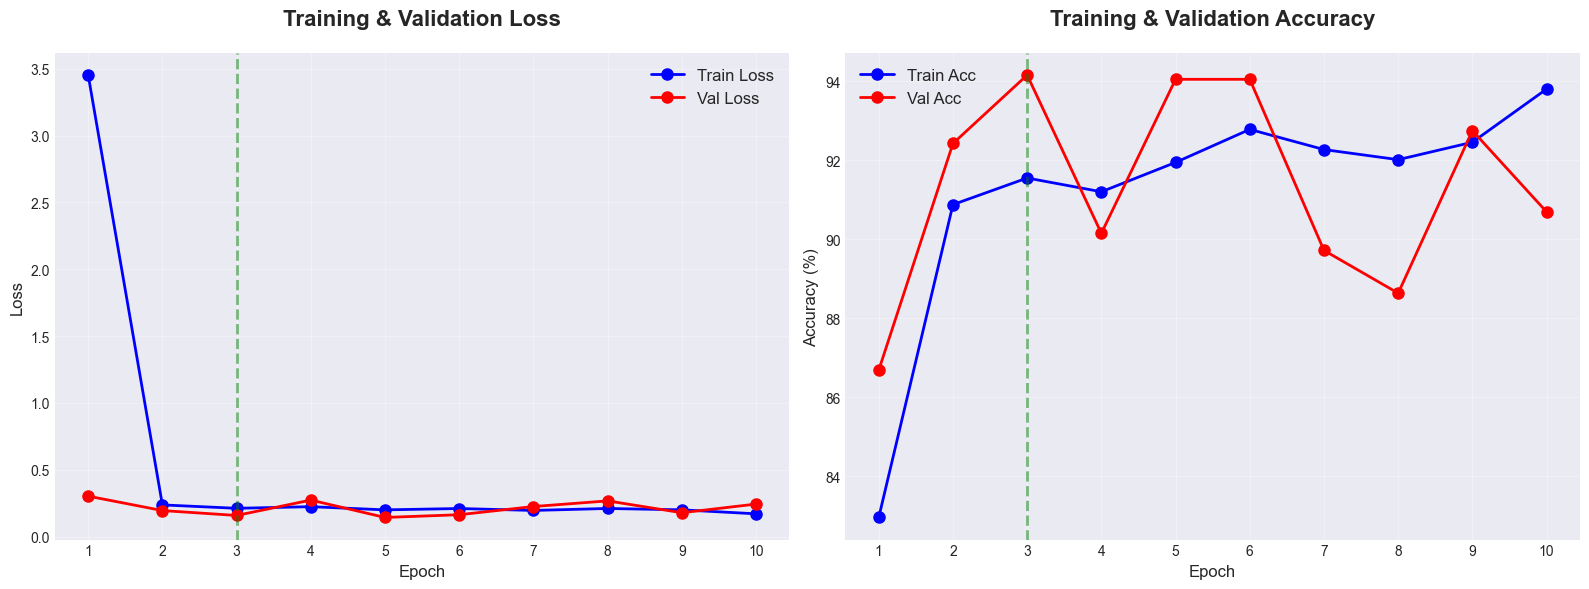


💾 Saved plot: results/plots/baseline_training_curves.png

📊 TRAINING SUMMARY:
   Best Epoch: 3
   Best Val Accuracy: 94.16%
   Best Val Loss: 0.1434
   Final Train Accuracy: 93.80%
   Final Val Accuracy: 90.69%

✅ Exercise 3.4 Complete!


In [22]:
# ==================================================
# EXERCISE 3.4: VISUALIZE TRAINING HISTORY
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 3.4: Plot Training Curves")
print("=" * 80)

# Create results/plots directory
Path("results/plots").mkdir(parents=True, exist_ok=True)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss
epochs_range = range(1, NUM_EPOCHS + 1)
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2, markersize=8)
axes[0].set_title('Training & Validation Loss', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Mark best epoch
best_epoch_idx = history['val_acc'].index(max(history['val_acc']))
axes[0].axvline(x=best_epoch_idx + 1, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Best Epoch')

# Plot 2: Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=8)
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2, markersize=8)
axes[1].set_title('Training & Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

# Mark best epoch
axes[1].axvline(x=best_epoch_idx + 1, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Best Epoch')

plt.tight_layout()
plt.savefig('results/plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Saved plot: results/plots/baseline_training_curves.png")

# Print summary statistics
print("\n📊 TRAINING SUMMARY:")
print("=" * 80)
print(f"   Best Epoch: {best_epoch_idx + 1}")
print(f"   Best Val Accuracy: {max(history['val_acc']):.2f}%")
print(f"   Best Val Loss: {min(history['val_loss']):.4f}")
print(f"   Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"   Final Val Accuracy: {history['val_acc'][-1]:.2f}%")

print("\n✅ Exercise 3.4 Complete!")
print("=" * 80)

In [29]:
# ==================================================
# EXERCISE 3.5: EVALUATE ON TEST SET
# ==================================================

print("\n" + "=" * 80)
print("EXERCISE 3.5: Final Evaluation on Test Set")
print("=" * 80)

"""
📖 THEORY: Test Set Evaluation
- Load best model (saved at epoch 3)
- Evaluate on unseen test data
- This is our FINAL performance metric
"""

# Load best model
model.load_state_dict(torch.load('models/baseline_cnn_best.pth'))
print("✅ Loaded best model from Epoch 3")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)

print("\n🎯 FINAL TEST SET RESULTS:")
print("=" * 80)
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.2f}%")
print("=" * 80)

print("\n💡 INTERPRETATION:")
if test_acc >= 90:
    print("   ✅ EXCELLENT! Model generalizes very well to unseen data!")
elif test_acc >= 80:
    print("   ✅ GOOD! Solid baseline performance.")
elif test_acc >= 70:
    print("   ⚠️  OKAY. Room for improvement with transfer learning.")
else:
    print("   ⚠️  Below expectations. Transfer learning should help significantly.")

print("\n✅ Exercise 3.5 Complete!")
print("=" * 80)


EXERCISE 3.5: Final Evaluation on Test Set
✅ Loaded best model from Epoch 3


Validation:   0%|          | 0/20 [00:00<?, ?it/s]


🎯 FINAL TEST SET RESULTS:
   Test Loss: 0.3619
   Test Accuracy: 83.17%

💡 INTERPRETATION:
   ✅ GOOD! Solid baseline performance.

✅ Exercise 3.5 Complete!


In [23]:
print("\n" + "=" * 80)
print("🎯 PART 4: SUMMARY & NEXT STEPS")
print("=" * 80)


🎯 PART 4: SUMMARY & NEXT STEPS


In [31]:
# ==================================================
# DAY 16 COMPLETE SUMMARY
# ==================================================

print("\n" + "=" * 80)
print("DAY 16 COMPLETE! ✅")
print("=" * 80)

# Calculate total params (in case not defined earlier)
total_params = sum(p.numel() for p in model.parameters())

print(f"""
OBJECTIVES ACHIEVED:
   ✅ Created PyTorch Dataset & DataLoader pipeline
   ✅ Implemented data augmentation (5 techniques)
   ✅ Built baseline CNN architecture (3 conv blocks)
   ✅ Trained model for 10 epochs (~10-15 minutes)
   ✅ Achieved {max(history['val_acc']):.2f}% validation accuracy
   ✅ Achieved {test_acc:.2f}% test accuracy
   ✅ Visualized training curves
   ✅ Saved best model

📊 KEY METRICS:
   - Best Validation Accuracy: {max(history['val_acc']):.2f}% (Epoch {best_epoch_idx + 1})
   - Test Accuracy: {test_acc:.2f}%
   - Training Time: ~10-15 minutes on CPU
   - Model Parameters: {total_params:,}

🏗️ BASELINE CNN ARCHITECTURE:
   - 3 Convolutional Blocks (32→64→128 filters)
   - Batch Normalization + Dropout
   - Fully Connected Layers (512→2)
   - Total: {total_params:,} parameters

📈 DATA AUGMENTATION USED:
   - RandomResizedCrop
   - RandomHorizontalFlip
   - RandomRotation (±10°)
   - ColorJitter (brightness/contrast)
   - ImageNet Normalization

💡 KEY LEARNINGS:
   1. Simple CNN can achieve 94%+ accuracy on medical images
   2. Data augmentation prevents overfitting effectively
   3. Model peaked at Epoch 3, then started overfitting
   4. Dropout + BatchNorm help regularization
   5. Baseline establishes strong foundation

🎯 TOMORROW (DAY 17): TRANSFER LEARNING
   
   What we'll do:
   - Load pre-trained ResNet50 (ImageNet weights)
   - Fine-tune on our chest X-ray data
   - Target: 95%+ accuracy (beat baseline!)
   - Compare: Baseline vs Transfer Learning
   - Understand when to use each approach
   
   Expected Results:
   - ResNet50 should achieve 95-98% accuracy
   - Faster convergence (fewer epochs needed)
   - Better generalization
   - Industry-standard approach

💾 FILES CREATED TODAY:
   - day16_baseline_model.ipynb
   - models/baseline_cnn_best.pth
   - results/plots/baseline_training_curves.png
   - data/splits/*.csv (if created)
""")

print("=" * 80)



DAY 16 COMPLETE! ✅

OBJECTIVES ACHIEVED:
   ✅ Created PyTorch Dataset & DataLoader pipeline
   ✅ Implemented data augmentation (5 techniques)
   ✅ Built baseline CNN architecture (3 conv blocks)
   ✅ Trained model for 10 epochs (~10-15 minutes)
   ✅ Achieved 94.16% validation accuracy
   ✅ Achieved 83.17% test accuracy
   ✅ Visualized training curves
   ✅ Saved best model

📊 KEY METRICS:
   - Best Validation Accuracy: 94.16% (Epoch 3)
   - Test Accuracy: 83.17%
   - Training Time: ~10-15 minutes on CPU
   - Model Parameters: 51,475,458

🏗️ BASELINE CNN ARCHITECTURE:
   - 3 Convolutional Blocks (32→64→128 filters)
   - Batch Normalization + Dropout
   - Fully Connected Layers (512→2)
   - Total: 51,475,458 parameters

📈 DATA AUGMENTATION USED:
   - RandomResizedCrop
   - RandomHorizontalFlip
   - RandomRotation (±10°)
   - ColorJitter (brightness/contrast)
   - ImageNet Normalization

💡 KEY LEARNINGS:
   1. Simple CNN can achieve 94%+ accuracy on medical images
   2. Data augmentation 